# Importing Libraries and Downloading Data

#### Import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
#import wandb
import seaborn as sns

#### Download data

In [5]:
(X, y), (X_test, y_test) = mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Dataset Preprocessing

In [6]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [7]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
X = X.T

#### Number of neurons in the input and output layers

In [8]:
input_nodes = num_features
output_nodes = num_classes

#### Class names

In [9]:
class_names = [0,1,2,3,4,5,6,7,8,9]

#### Print Sample Images

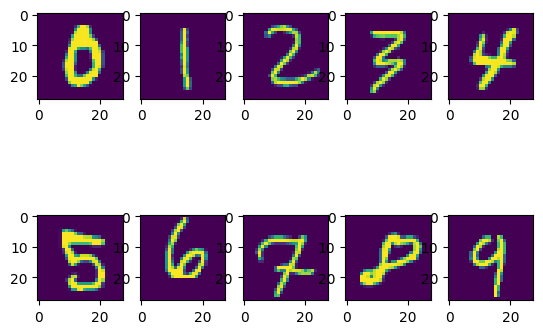

In [10]:
# Store the index of first occurrence of each class
example_indices = [list(y_train).index(i) for i in range(num_classes)]

fig=plt.figure()
count = 1
for index in example_indices:
    fig.add_subplot(2,5,count)
    plt.imshow(X_train.T[index].reshape((28, 28)))
    count+=1


# Components of the Neural Network Model

#### Activation functions and their derivatives

In [11]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

def compute_multiclass_loss(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    #Add L2 regularisation
    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [12]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    '''Function to initialise weights, biases and velocities/previous updates of the NN

    Parameters
    ----------
    layer_dims: list
        list of number of neurons per layer specifying layer dimensions in the format [#input_features,#hiddenunits...#hiddenunits,#outputclasses]

    init_mode: string
        initialisation mode, default-"xavier"

    Returns
    -------
    params: dict
        contains weights and biases. eg params[W1] is weight for layer 1

    previous updates: dict
        previous updates initialisation. This is used for different perposes for different optimisers.

    '''
    np.random.seed(42)
    params = {}
    previous_updates = {}

    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [13]:
def forward_propagate(X, params, activation_f):
    '''Function to forward propagate a minibatch of data once through the NN

    Parameters
    ----------
    X: numpy array
        data in (features,batch_size) format

    params: dict
        W and b of the NN

    activation_f: string
        activation function to be used except the output layer

    Returns
    -------
    output: numpy array
        contains the output probabilities for each class and each data sample after 1 pass
    A: numpy array
        contains all post-activations
    Z: numpy array
        contsins all pre-activations

    '''
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b 
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [14]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    '''Function to calculate gradients for a minibatch of data once through the NN through backpropagation

    Parameters
    ----------
    y_hat: numpy array
        output from forward propagation/ class probabilities

    y: numpy array
        actual class labels
     
    A: numpy array
        post-activations

    Z: numpy array
        pre-activations   

    params: dict
        contains W and b on the NN   

    activation_f: string
        activation function to be used except the output layer

    batch_size: int
        mini-batch-size

    loss: string
        loss function (MSE/Categorical crossentropy)

    lamb: float
        L2 regularisation lambda

    Returns
    -------
    gradients: dict
        gradients wrt weights and biases

    '''
    L = len(params)//2 #no. of layers
    gradients = {}
    
    #process last layer which has softmax
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    #process other layers
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1: 
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [15]:
def update_params_sgd(parameters,grads,learning_rate):
    ''' Update W and b of the NN according to sgd updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    Returns
    -------
    parameters: dict
        updated NN parameters

    '''
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    ''' Update W and b of the NN according to momentum updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    previous_updates: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        previous_updates[Wi] = beta*previous_updates[Wi] + (1-beta)*gradient[dWi]

    Returns
    -------
    parameters: dict
        updated NN parameters

    previous updates: dict
        updated previous updates 

    '''
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):
    ''' Update W and b of the NN according to RMSprop updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate
    
    beta: float
        decay rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients square eg.
        v[Wi] = beta*v[Wi] + (1-beta)*(gradient[dWi]^2)

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated "velocities"

    '''

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    ''' Update W and b of the NN according to adam updates

    Parameters
    ----------
    parameters: dict
        contains weights and biases of the NN

    grads: dict
        contains gradients wrt W and b returned by backpropagation

    learning_rate: float
        learning rate

    v: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients eg.
        v[Wi] = beta1*v[Wi] + (1-beta1)*(gradient[dWi])

    m: dict
        contains previous W and b values, accumulated in a weighted fashion along with the gradients^2 eg.
        v[Wi] = beta2*v[Wi] + (1-beta2)*(gradient[dWi]^2)

    t: int
        timestep for Adam

    Returns
    -------
    parameters: dict
        updated NN parameters

    v: dict
        updated previous updates

    m: dict
        updated "velocities"

    t: int
        updated timestep

    '''
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9 #default
    beta2 = 0.999 #default
    epsilon = 1e-8 #for numerical stability

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

######## Enter your new optimiser updates function here #############
#                                                                   #
#####################################################################

#### Function to plot the cost curves

In [16]:
def plot_cost_curve(train_costs, val_costs):
    '''
    Plots the train and validation cost curves
    '''
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Prediction and Evaluation functions

In [17]:
def NN_predict(X_test, params, activation_f):
    '''
    forward propagate once and calculate labels

    '''
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    '''
    print train,test accuracies and the classification report using sklearn

    '''
    train_predictions = NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

# Training the model with the best combination of hyperparameters

#### Training on the full dataset

In [18]:
def NN_fit(X_train, y_train_one_hot,X_val,y_val_one_hot, learning_rate = 0.001, activation_f = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                layer_dims=[]):
    """This function is used to train the neural network on the dataset 

    X_train: numpy array
        train dataset

    y_train_one_hot: numpy array
        train labels with one-hot encoding

    learning_rate: float

    activation_f: string
        activation functions for all the layers except the last layer which is softmax

    init_mode: string
        initialization mode
    
    optimizer: string
        optimization routine

    bach_size: int
        minibatch size

    loss: string
        loss function

    epochs: int
        number of epochs to be used

    L2_lamb: float
        lambda for L2 regularisation of weights

    num_neurons: int
        number of neurons in every hidden layer

    num_hidden: 
        number of hidden layers

    Returns
    -------

    parameters: dict
        weights and biases of the NN model

    epoch_cost: list
        training costs with every epoch
    

    """


    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost=[]
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs

        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size

            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1
            
            #process all nesterov accelerated optimisers

            #NAG
            if optimizer == 'nesterov':
                L = len(params)//2

                #look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)

                #call momentum
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)

            #nadam
            elif optimizer=='nadam':
                L = len(params)//2

                #look ahead logic
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)

                #call adam
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            #custom
            elif optimizer == 'insert your nesterov accelerated optimiser here':
                #insert your optimiser here if it is nesterov accelerated

                #insert lookahead logic here

                #for weight updates, call that optimiser's weight update code here
                pass

            #process all other optimisers

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

                #custom
                elif optimizer == 'insert your optimiser here':
                    #insert your optimiser update routine only if it does not have nesterov 
                    pass

                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)


    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)


    return params, epoch_cost

In [19]:
#hyperparameters

LEARNING_RATE = 0.001
ACTIVATION = "relu"
INITIALIZER = "xavier"
OPTIMIZER = "RMSprop"
BATCH_SIZE = 512
EPOCHS = 40
L2_lambda = 0.0005
LAYER_DIMS = [784,64,32,64,10]

LOSS = 'categorical_crossentropy'

Epoch number:  2 	Training cost: 0.2972411295796833
Epoch number:  4 	Training cost: 0.1796466878659444
Epoch number:  6 	Training cost: 0.13201002117958532
Epoch number:  8 	Training cost: 0.10934768263503328
Epoch number:  10 	Training cost: 0.08769092778010251
Epoch number:  12 	Training cost: 0.07083312798147127
Epoch number:  14 	Training cost: 0.05616295419535783
Epoch number:  16 	Training cost: 0.04399845755513987
Epoch number:  18 	Training cost: 0.037191204008080216
Epoch number:  20 	Training cost: 0.03155038887287473
Epoch number:  22 	Training cost: 0.028963650760542727
Epoch number:  24 	Training cost: 0.023002395443528296
Epoch number:  26 	Training cost: 0.024164441818408357
Epoch number:  28 	Training cost: 0.017187312198020225
Epoch number:  30 	Training cost: 0.020981070564101176
Epoch number:  32 	Training cost: 0.014236577485573405
Epoch number:  34 	Training cost: 0.011429860072138694
Epoch number:  36 	Training cost: 0.01186087020442785
Epoch number:  38 	Trainin

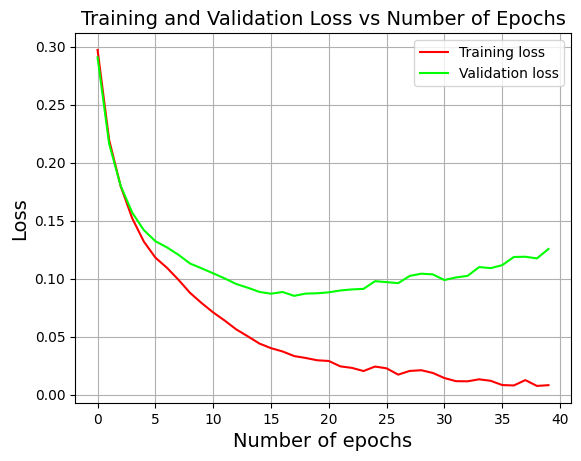

In [20]:

learned_parameters, epoch_cost = NN_fit(X_train, y_train_one_hot,
                            X_val,y_val_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            layer_dims = LAYER_DIMS)

#### Model Evaluation with X_test dataset

In [21]:
train_predictions, test_predictions = NN_evaluate(X_train, y_train, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 99.748 %
Test accuracy = 97.18 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.95      0.97       892
           6       0.97      0.98      0.98       958
           7       0.95      0.98      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

